In [1]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import SGD, Optimizer
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
sess = tf.Session()
K.set_session(sess)

Using TensorFlow backend.


In [58]:
class SGD(Optimizer):
    """Stochastic gradient descent optimizer.

    Includes support for momentum,
    learning rate decay, and Nesterov momentum.

    # Arguments
        lr: float >= 0. Learning rate.
        momentum: float >= 0. Parameter updates momentum.
        decay: float >= 0. Learning rate decay over each update.
        nesterov: boolean. Whether to apply Nesterov momentum.
    """

    def __init__(self, lr=0.01, momentum=0., decay=0.,
                 nesterov=False, **kwargs):
        super(SGD, self).__init__(**kwargs)
        self.iterations = K.variable(0., name='iterations')
        self.lr = K.variable(lr, name='lr')
        self.momentum = K.variable(momentum, name='momentum')
        self.decay = K.variable(decay, name='decay')
        self.initial_decay = decay
        self.nesterov = nesterov

    def get_updates(self, params, constraints, loss):
        grads = self.get_gradients(loss, params)
        self.updates = []

        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * self.iterations))
            self.updates .append(K.update_add(self.iterations, 1))

        # momentum
        shapes = [K.get_variable_shape(p) for p in params]
        moments = [K.zeros(shape) for shape in shapes]
        self.weights = [self.iterations] + moments
        for p, g, m in zip(params, grads, moments):
            v = self.momentum * m - lr * g  # velocity
            self.updates.append(K.update(m, v))

            if self.nesterov:
                new_p = p + self.momentum * v - lr * g
            else:
                new_p = p + v

            # apply constraints
            if p in constraints:
                c = constraints[p]
                new_p = c(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'momentum': float(K.get_value(self.momentum)),
                  'decay': float(K.get_value(self.decay)),
                  'nesterov': self.nesterov}
        base_config = super(SGD, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [16]:
class SGDWithAcc(Optimizer):
    """Stochastic gradient descent optimizer.

    Includes support for momentum,
    learning rate decay, and Nesterov momentum.

    # Arguments
        lr: float >= 0. Learning rate.
        momentum: float >= 0. Parameter updates momentum.
        decay: float >= 0. Learning rate decay over each update.
        nesterov: boolean. Whether to apply Nesterov momentum.
        accum_iters: int >= 1. Accumulate gradients over several
            iterations before updating weights.
    """

    def __init__(self, lr=0.01, momentum=0., decay=0.,
                 nesterov=False, accum_iters=1, **kwargs):
        super(SGDWithAcc, self).__init__(**kwargs)
        self.iterations = K.variable(0., name='iterations')
        self.lr = K.variable(lr, name='lr')
        self.momentum = K.variable(momentum, name='momentum')
        self.decay = K.variable(decay, name='decay')
        self.initial_decay = decay
        self.nesterov = nesterov
        self.accum_iters = K.variable(accum_iters)
        self.debug = []
        print("Init")

    def get_updates(self, params, constraints, loss):
        print("Call")
        grads = self.get_gradients(loss, params)
        self.updates = []

        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * self.iterations))
            self.updates .append(K.update_add(self.iterations, 1))

        # momentum
        shapes = [K.get_variable_shape(p) for p in params]
        moments = [K.zeros(shape) for shape in shapes]
        # Accumulated gradients
        grads_acc = [K.zeros(shape) for shape in shapes]

        self.weights = [self.iterations] + moments
        
        for p, g, m, gacc in zip(params, grads, moments, grads_acc):
            # 1 if we update the gradient, 0 otherwise
            update = K.cast(K.equal(self.iterations % self.accum_iters, self.accum_iters - 1), K.floatx())
            
            # if no update, g_t = 0, just keep accumulating
            g_t = update * ((gacc + g) / self.accum_iters)
            
            v = self.momentum * m - lr * g_t  # velocity
            self.updates.append(K.update(m, (1 - update) * m + update * v))
            self.updates.append((gacc, (1 - update) * (gacc + g)))

            if self.nesterov:
                new_p = p + update * (self.momentum * v - lr * g_t)
            else:
                new_p = p + update * v

            # apply constraints
            if p in constraints:
                c = constraints[p]
                new_p = c(new_p)

            self.updates.append(K.update(p, new_p))
        print(self.updates)
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'momentum': float(K.get_value(self.momentum)),
                  'decay': float(K.get_value(self.decay)),
                  'nesterov': self.nesterov,
                  'accum_iters': self.accum_iters}
        base_config = super(SGDWithAcc, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [17]:
n = 20
x = np.linspace(-n/2, n/2, n)
y = 2 * x + 1 + np.random.randn(n)

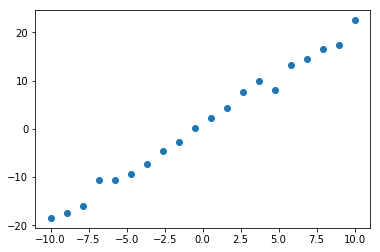

In [18]:
plt.scatter(x, y)

In [19]:
def loss(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

In [59]:
np.random.seed(42)
opt = SGD(lr=0.1, momentum=0.9, nesterov=True)
model_input = Input(batch_shape=(4, 1))
model_output = Dense(1, activation=None)(model_input)
model = Model(inputs=[model_input], outputs=[model_output])
model.compile(optimizer=opt, loss=loss)
model.train_on_batch(x[:4], y[:4])
model.train_on_batch(x[4:8], y[4:8])

4.3927393

In [60]:
def get_gradients(model):
    """Return the gradient of every trainable weight in model

    Parameters
    -----------
    model : a keras model instance

    First, find all tensors which are trainable in the model. Surprisingly,
    `model.trainable_weights` will return tensors for which
    trainable=False has been set on their layer (last time I checked), hence the extra check.
    Next, get the gradients of the loss with respect to the weights.

    """
    weights = [tensor for tensor in model.trainable_weights if model.get_layer(tensor.name.split("/")[0]).trainable]
    optimizer = model.optimizer

    return optimizer.get_gradients(model.total_loss, weights)

In [61]:
g = model.trainable_weights[0]

In [62]:
g.name

'dense_9/kernel:0'

In [63]:
for l in model.layers:
    print(l.name)

input_9
dense_9


In [64]:
K.eval(get_gradients(model)[0])

InvalidArgumentError: Shape [-1] has negative dimensions
	 [[Node: dense_9_sample_weights = Placeholder[dtype=DT_FLOAT, shape=[?], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'dense_9_sample_weights', defined at:
  File "/usr/local/Cellar/python3/3.6.0_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python3/3.6.0_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/l.chanussot/virtualenvs/tiger/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/l.chanussot/virtualenvs/tiger/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/l.chanussot/virtualenvs/tiger/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/l.chanussot/virtualenvs/tiger/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/l.chanussot/virtualenvs/tiger/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/l.chanussot/virtualenvs/tiger/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/l.chanussot/virtualenvs/tiger/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/l.chanussot/virtualenvs/tiger/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/l.chanussot/virtualenvs/tiger/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/l.chanussot/virtualenvs/tiger/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/l.chanussot/virtualenvs/tiger/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/l.chanussot/virtualenvs/tiger/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/l.chanussot/virtualenvs/tiger/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/l.chanussot/virtualenvs/tiger/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/l.chanussot/virtualenvs/tiger/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/l.chanussot/virtualenvs/tiger/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/l.chanussot/virtualenvs/tiger/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/l.chanussot/virtualenvs/tiger/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-59-e565af98474f>", line 6, in <module>
    model.compile(optimizer=opt, loss=loss)
  File "/Users/l.chanussot/virtualenvs/tiger/lib/python3.6/site-packages/keras/engine/training.py", line 799, in compile
    name=name + '_sample_weights'))
  File "/Users/l.chanussot/virtualenvs/tiger/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 432, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/Users/l.chanussot/virtualenvs/tiger/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1530, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/Users/l.chanussot/virtualenvs/tiger/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1954, in _placeholder
    name=name)
  File "/Users/l.chanussot/virtualenvs/tiger/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/Users/l.chanussot/virtualenvs/tiger/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/l.chanussot/virtualenvs/tiger/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Shape [-1] has negative dimensions
	 [[Node: dense_9_sample_weights = Placeholder[dtype=DT_FLOAT, shape=[?], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [ ]:
np.random.seed(42)
opt = SGDWithAcc(lr=0.1, momentum=0.9, nesterov=True, accum_iters=2)
model_input = Input(shape=(1, ))
model_output = Dense(1, activation=None)(model_input)
model = Model(inputs=[model_input], outputs=[model_output])
model.compile(optimizer=opt, loss=loss)

In [49]:
model.train_on_batch(x[:2], y[:2])
model.train_on_batch(x[2:4], y[2:4])
model.train_on_batch(x[4:6], y[4:6])
model.train_on_batch(x[6:8], y[6:8])

Call
[<tf.Tensor 'Assign_18:0' shape=(1, 1) dtype=float32_ref>, (<tf.Variable 'Variable_29:0' shape=(1, 1) dtype=float32_ref>, <tf.Tensor 'mul_75:0' shape=(1, 1) dtype=float32>), <tf.Tensor 'Assign_19:0' shape=(1, 1) dtype=float32_ref>, <tf.Tensor 'Assign_20:0' shape=(1,) dtype=float32_ref>, (<tf.Variable 'Variable_30:0' shape=(1,) dtype=float32_ref>, <tf.Tensor 'mul_84:0' shape=(1,) dtype=float32>), <tf.Tensor 'Assign_21:0' shape=(1,) dtype=float32_ref>]


1.8641242

In [ ]:
l = model.weights[0]

In [ ]:
l.eval(sess)

In [ ]:
opt.debug

In [ ]:
l = model.weights[0]

In [ ]:
l.eval(sess)